In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import pandas as pd
from skimage import io, transform
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
import glob
import gc
from gan_utils import *

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
ngpu = 1
nz = 32
ngf = 64
ndf = 64
nc = 3
mask_sizes = [2,4,8,16]
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print('device:', device)

device: cuda:0


In [3]:
df = pd.read_csv('imagenet_flowers/mask_pred_dict_sampled.csv')
files = df['file'].values
image_paths = [os.path.join('imagenet_flowers/flower64', file) for file in files]
mask_paths = [os.path.join('imagenet_flowers/mask_pred64', file) for file in files]
del df
gc.collect()
my_transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
realflower = flower_dataset(image_paths, mask_paths,
                            mask_sizes = mask_sizes,
                            transform = my_transform,
                            mask_transform = my_transform,
                            in_memory = True)

image_paths = glob.glob("imagenet_nonflowers/nonflower64/*_1.jpg")
realnonflower = flower_dataset(image_paths,
                               mask_sizes = mask_sizes,
                               transform = my_transform,
                               in_memory = True)

realdata = ConcatDataset([realflower, realnonflower])                               
dataloader = DataLoader(realdata, batch_size=128, shuffle=True, num_workers=1)

0it [00:00, ?it/s]/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
66766it [04:04, 273.26it/s]
10676it [00:05, 1862.33it/s]


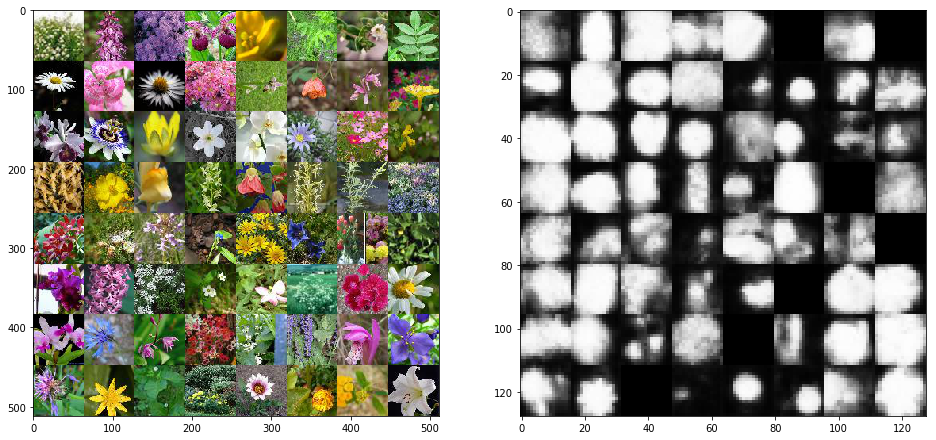

In [4]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("Training Images")
plt.subplot(1,2,1)
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=0, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.imshow(np.transpose(vutils.make_grid(real_batch[1][-1].to(device)[:64], padding=0, normalize=True).cpu(),(1,2,0)))
plt.show()

In [5]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.layer1 = nn.Sequential(
            # input is Z, going into a convolution
            # input Z(32,2,2)
            nn.ConvTranspose2d(nz + 1, ngf * 8, 4, 2, 0, bias=False),
            nn.ReflectionPad2d(-1),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True)
        )
        self.layer2 = nn.Sequential(
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8 + 1, ngf * 4, 4, 2, 0, bias=False),
            nn.ReflectionPad2d(-1),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True)
        )
        self.layer3 = nn.Sequential(
            # state size. (ngf*4) x 8 x 8            
            nn.ConvTranspose2d(ngf * 4 + 1, ngf * 2, 4, 2, 0, bias=False),
            nn.ReflectionPad2d(-1),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True)
        )
        self.layer4 = nn.Sequential(
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2 + 1, ngf, 4, 2, 0, bias=False),
            nn.ReflectionPad2d(-1),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True)
        )
        self.layer5 = nn.Sequential(
            # state size. (ngf) x 32 x 32            
            nn.ConvTranspose2d(ngf, nc, 4, 2, 0, bias=False),
            nn.ReflectionPad2d(-1),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, noise, mask):
        x = torch.cat((noise, mask[0]), dim=1) #2*2
        x = self.layer1(x)
        x = torch.cat((x, mask[1]), dim=1) #4*4
        x = self.layer2(x)
        x = torch.cat((x, mask[2]), dim=1) #8*8
        x = self.layer3(x)
        x = torch.cat((x, mask[3]), dim=1) #16*16
        x = self.layer4(x)
        x = self.layer5(x)
        return x
    
    
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)
print("netG parameters:", [p.numel() for p in netG.parameters() if p.requires_grad])

Generator(
  (layer1): Sequential(
    (0): ConvTranspose2d(33, 512, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): ReflectionPad2d((-1, -1, -1, -1))
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace)
  )
  (layer2): Sequential(
    (0): ConvTranspose2d(513, 256, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): ReflectionPad2d((-1, -1, -1, -1))
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace)
  )
  (layer3): Sequential(
    (0): ConvTranspose2d(257, 128, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): ReflectionPad2d((-1, -1, -1, -1))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace)
  )
  (layer4): Sequential(
    (0): ConvTranspose2d(129, 64, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): ReflectionPad2d((-1, -1, -1, -1))
    (2): BatchNorm2d(64, eps=1e-05, momentum

In [6]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.layer1 = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.layer2 = nn.Sequential(
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.layer3 = nn.Sequential(
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2 + 1, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.layer4 = nn.Sequential(
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4 + 1, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.layer5 = nn.Sequential(
        # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8 + 1, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, image, mask):
        x = self.layer1(image)
        x = self.layer2(x)
        x = torch.cat((x, mask[3]), dim=1) #16*16
        x = self.layer3(x)
        x = torch.cat((x, mask[2]), dim=1) #8*8
        x = self.layer4(x)
        x = torch.cat((x, mask[1]), dim=1) #4*4
        x = self.layer5(x)
        return x
    
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)
print("netD parameters", [p.numel() for p in netD.parameters() if p.requires_grad])

Discriminator(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (layer3): Sequential(
    (0): Conv2d(129, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (layer4): Sequential(
    (0): Conv2d(257, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (layer5): Sequential(
    (0): Conv2d(513, 1, kernel_size

torch.Size([64, 1, 1, 1])

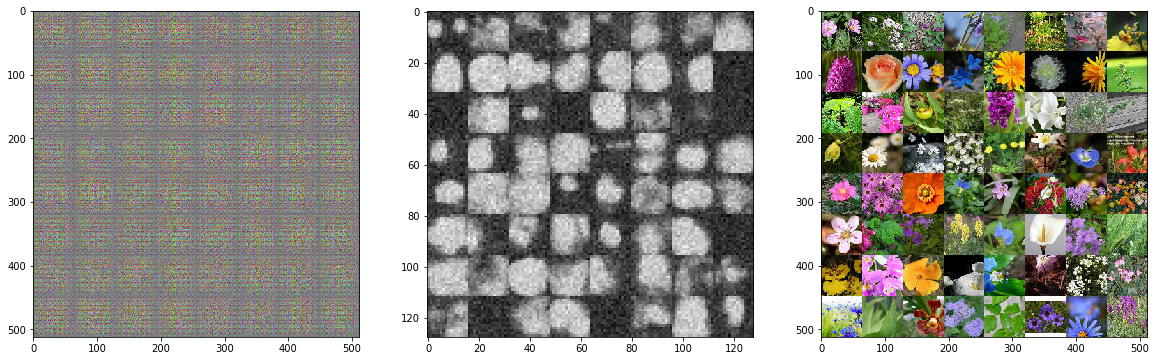

In [7]:
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 2, 2, device=device)
fixed_mask = [torch.randn(64, 1, size, size, device=device, dtype=torch.float32) * 0.2 for size in mask_sizes]
fixed_image = torch.zeros(64, 3, 64, 64, device=device)
for i in range(64):
    n = np.random.randint(len(realdata))
    for k, mask in enumerate(fixed_mask):
        mask[i,:,:,:] += realdata[n][1][k].to(device)
    fixed_image[i,:,:,:] = realdata[n][0]

fake_image = netG(fixed_noise, fixed_mask)
output = netD(fake_image, fixed_mask)
#show_image_n_mask((fake_image[0].detach().cpu(), mask[0].detach().cpu())), output.cpu()
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.imshow(np.transpose(vutils.make_grid(fake_image.detach(), padding=0, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,3,2)
plt.imshow(np.transpose(vutils.make_grid(fixed_mask[-1].detach(), padding=0, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,3,3)
plt.imshow(np.transpose(vutils.make_grid(fixed_image.detach(), padding=0, normalize=True).cpu(),(1,2,0)))
output.size()

In [8]:
fixed_mask2 = sample_mask(64, sizes = mask_sizes, realdata=realdata, device=device)
labels = mask_pair_to_label(fixed_mask, fixed_mask2, device=device)
labels, labels.mean()

(tensor([0.3589, 0.5996, 0.6270, 0.5621, 0.5106, 0.6417, 0.6362, 0.6172, 0.7035,
         0.5168, 0.5933, 0.4800, 0.3211, 0.2829, 0.5502, 0.8930, 0.8854, 0.7303,
         0.7437, 0.7337, 0.2808, 0.5943, 0.8599, 0.3466, 0.5770, 0.7485, 0.7216,
         0.3997, 0.8314, 0.6214, 0.5555, 0.4572, 0.5728, 0.3974, 0.6879, 0.7896,
         0.6159, 0.7105, 0.5694, 0.7803, 0.4051, 0.4188, 0.7316, 0.3328, 0.4050,
         0.7422, 0.7125, 0.7653, 0.7171, 0.5833, 0.3818, 0.5076, 0.5384, 0.5734,
         0.6284, 0.7353, 0.5603, 0.7173, 0.5862, 0.7164, 0.6543, 0.6280, 0.6481,
         0.6548], device='cuda:0'), tensor(0.6008, device='cuda:0'))

In [9]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
lr = 0.0002
beta1 = 0.5
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop
!mkdir model_checkpoints
!mkdir sample_images
!mkdir sample_images/gan_z22_masks

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 100
start_epoch= 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(start_epoch, start_epoch+num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_image = data[0].to(device)
        real_mask = [noise_input(x, noise_level=0.2, device=device) for x in data[1]]
        #real_cpu = noise_input(data, noise_level=0.2*np.exp(-epoch/100.0), device=device)
        b_size = real_image.size(0)
        label = torch.full((b_size,), real_label, device=device)
        #label = get_label(b_size, real_label, soft=0.2, noise=True, noise_level=0.1, device=device)
        # Forward pass real batch through D
        output = netD(real_image, real_mask).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 2, 2, device=device)
        mask = sample_mask(b_size, sizes=mask_sizes, realdata=realdata, device=device)
        # Generate fake image batch with G
        fake_image = netG(noise, mask)
        label.fill_(fake_label)
        #label = get_label(b_size, fake_label, soft=0.2, noise=True, noise_level=0.1, device=device)
        # Classify all fake batch with D
        output = netD(fake_image.detach(), mask).view(-1)
        #print("output1",output[:5])
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label) * (1.5-sigmoid(epoch+start_epoch)) 
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        # Train with real-image and unmatched masks
        label = mask_pair_to_label(mask, real_mask, device=device)
        output = netD(real_image, mask).view(-1)
        errD_unmatch = criterion(output, label) * (sigmoid(epoch+start_epoch)-0.5)
        errD_unmatch.backward()
        D_G_z3 = output.mean().item()
        
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake + errD_unmatch
        # Update D
        optimizerD.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        #label = get_label(b_size, real_label, soft=0.2, noise=False, device=device)
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake_image, mask).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()        
               
        # Output training stats
        if i % 128 == 0:
            print('[%d/%d][%d/%d]  Loss_D: %.4f (%.4f / %.4f / %.4f). Loss_G: %.4f  D(x): %.4f  D(G(z)): %.4f / %.4f / %.4f'
                  % (epoch-start_epoch, num_epochs, i, len(dataloader),
                     errD.item(), errD_real.item(), errD_fake.item(), errD_unmatch.item(), errG.item(), D_x, D_G_z1, D_G_z2, D_G_z3))
            Dgradnorm_first = list(netD.parameters())[0].grad.norm()
            Ggradnorm_first = list(netG.parameters())[0].grad.norm()
            Ggradnorm_last = list(netG.parameters())[-1].grad.norm()
            print("Ggradnorm first: %.4f\t Ggradnormlast: %.4f\t Dgradnormlast: %.4f"%(Ggradnorm_first, Ggradnorm_last, Dgradnorm_first))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake_image = netG(fixed_noise, fixed_mask).detach().cpu()
            image_tensor = vutils.make_grid(fake_image, padding=2, normalize=True)
            img_list.append(image_tensor)
            filepath = 'sample_images/gan_z22_masks/ep'+str(epoch)+'_itr'+str(i)+'.jpg'
            io.imsave(filepath, image_tensor.numpy().transpose(1,2,0))

        iters += 1
        
    if epoch%20==0:
        checkpoint_path = "model_checkpoints/GAN_z22_mask_ep"+str(epoch)
        print('save model to %s'%checkpoint_path)
        torch.save({
            'netG_state_dict': netG.state_dict(),
            'netD_state_dict': netD.state_dict(),
            'optimizerG_state_dict': optimizerG.state_dict(),
            'optimizerD_state_dict': optimizerD.state_dict(),
            }, checkpoint_path)
        
print('Done')

mkdir: cannot create directory ‘model_checkpoints’: File exists
mkdir: cannot create directory ‘sample_images’: File exists
mkdir: cannot create directory ‘sample_images/gan_z22_masks’: File exists
Starting Training Loop...
[0/100][0/606]  Loss_D: 1.8143 (0.9863 / 0.8280 / 0.0000). Loss_G: 6.0180  D(x): 0.4400  D(G(z)): 0.4960 / 0.0040 / 0.4375
Ggradnorm first: 11.9331	 Ggradnormlast: 23.9549	 Dgradnormlast: 13.9491


/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


[0/100][128/606]  Loss_D: 0.2514 (0.1517 / 0.0996 / 0.0000). Loss_G: 4.3564  D(x): 0.8751  D(G(z)): 0.0894 / 0.0199 / 0.8851
Ggradnorm first: 3.6448	 Ggradnormlast: 25.3024	 Dgradnormlast: 32.0530
[0/100][256/606]  Loss_D: 0.9738 (0.8592 / 0.1146 / 0.0000). Loss_G: 3.9041  D(x): 0.5923  D(G(z)): 0.0940 / 0.0561 / 0.5873
Ggradnorm first: 4.0472	 Ggradnormlast: 28.0078	 Dgradnormlast: 44.8718
[0/100][384/606]  Loss_D: 0.5332 (0.3260 / 0.2072 / 0.0000). Loss_G: 4.2309  D(x): 0.7620  D(G(z)): 0.1723 / 0.0250 / 0.7051
Ggradnorm first: 3.3386	 Ggradnormlast: 21.1325	 Dgradnormlast: 44.6889
[0/100][512/606]  Loss_D: 0.5849 (0.0634 / 0.5215 / 0.0000). Loss_G: 4.5186  D(x): 0.9433  D(G(z)): 0.3806 / 0.0157 / 0.9083
Ggradnorm first: 3.2114	 Ggradnormlast: 17.9958	 Dgradnormlast: 32.1426
save model to model_checkpoints/GAN_z22_mask_ep0
[1/100][0/606]  Loss_D: 5.8578 (0.0012 / 5.8406 / 0.0160). Loss_G: 4.5699  D(x): 0.9988  D(G(z)): 0.9893 / 0.0706 / 0.9986
Ggradnorm first: 3.7138	 Ggradnormlast: 

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
plt.imshow(np.transpose(vutils.make_grid(img_list[-1], padding=0, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,3,2)
plt.imshow(np.transpose(vutils.make_grid(fixed_mask[-1].detach(), padding=0, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,3,3)
plt.imshow(np.transpose(vutils.make_grid(fixed_image.detach(), padding=0, normalize=True).cpu(),(1,2,0)))

In [ ]:
torch.save({
            'netG_state_dict': netG.state_dict(),
            'netD_state_dict': netD.state_dict(),
            'optimizerG_state_dict': optimizerG.state_dict(),
            'optimizerD_state_dict': optimizerD.state_dict(),
            }, "model_checkpoints/GAN_z22_mask")